# Exercise Baires Dev
Applicant: Joaquín Amiel



## Introduccion
BairesDev specializes in delivering technology solutions. One of our engagement models is IT Staff Augmentation, where our engineers are an extension of the client’s teams. Most of our developers (approx 95%) are located in LATAM

We have developed an email marketing application to expand our client’s portfolio. The main responsibilities of the system are extracting data and sending email campaigns to potential customers.





### Data
We are attaching two folders containing:
- **Contacts**: Information about the leads that we have contacted in the past. It includes a file called *Contacts_Positive* with information about leads that replied interested (*Sucess*) and several *ContactsN* files with mostly no replies or not interested contacts (*Failure*). The file has a column score that represents the business value that our sales team assigned to the potential customer, based on their profile (whether he is a decision-maker or not) and the potential of the opportunity (whether he is requesting one resource or a team of 20 developers).
- **Data**: Leads that we are planning to contact (**they may have been contacted in the past**).



### Request

We request you to analyze the data and try to predict which people from the Data files have the highest chances of increasing the business value if contacted. The expected output is at least a document explaining the analysis and a sheet including the rows of the potential leads we should send an email to.
- We tried to provide you with enough data to draw some conclusions. However, if you think the provided sample is not statistically significant or is missing key information, please let us know :-)
- Which additional data do you think would be relevant to improve the algorithm?

## Executive brief
### Solution proposed:

To establish which people from the data files have the highest chances of increasing the business value if contacted, it is proposed to consider as the business value of a lead as the product of the probability of being interested and the score given interest in the job position.

$Value = Probability(Interest) * Expected(Score/Interest)$

This aspect is crucial, because one lead can have a high probability of interest but a poor score, and maybe its value is worse than the value of another lead with fewer probability of interest and a bigger score.

For this reason, our problem is divided into 2 parts, a first part is focused on predicting if a lead will have interest on the position and a second part refers to predict the score given interest in the job position.

###About the data

Although the database meets the minimum necessary requirements, because valuable conclusions can be drawn from it. It contains only locative data and data about the current position of the lead (company / position). However, it is considered that there are other aspects that can influence when a person is changing a job and / or hearing about a new opportunity:
- **Personal**: seniority in the position, age, marital status, number of children.
- **External conditions**: Economy of the country, evolution on the  dollar's price, situation of the city, volume of onsite jobs and opportunities in the city (it would take a little more time to get and incorporate this information).
- **Additional information**: email (for example, a hotmail which is old or a job email is not the same as a gmail), lead from a referral plan.
- **Historical information**: Number of previous contacts (as the time when the lead was generated), if the user previously worked at BairesDev.
- **Psychographic Variables**: Personality, lifestyles, interests, likes, concerns. Although it is recognized that this information is difficult to access, it is extremely valuable, since the work is for IT and is mainly remote, the profile of the employee is particular.
 
###Relevant conclusions

**Descriptive**

1.  The percentage of people interested decrease, when the number of employees in the company where they worked increase. This is expectable because in big companies (with some time in the market) people can develop a career and are less willing to consider a change. 
2. Segment of people which could be more interested in a job position:
  - CEO
  - Founders
  - Canadian
  - Education employees
  - Technology employees
3. Segment of people which could be less interested in a job position:
  - Project managers
  - Manager

**Modelling**

- if only the data that the model predicts as a possible interest (39.7% of leads) was kept, instead of having a success rate of 2.6%, we will have a 4.2%, which represents an increase of 61.8%, retaining 39.7% of leads.

- There is a relationship between the score and the probability of being hired. It is known that BairesDev hires 1% of developers. Therefore, it is observed that scores greater than 1 have a "high probability" of being hired (11.25% of leads) and scores less than 1 have a "very low probability" of being hired (88.75% of leads).

- The baseline score (taken just the average score) is improved by 3.55% using a regression technique.

**How many people are going to send in the list?**

- In BairesDev the mission is "We lead the digital transformation of companies worldwide driven by the Top 1% IT Talent", for this reason it is assumed that only 1% of the leads interested are finally hired (without any score filter).
- From the task letter, it is evident that the list must ensure at least the hiring of a big team of 20 developers.

**Potential leads**
- The initial database was considerably reduced, achieving the aim of hiring 20 people (with a probability of 75%) with only 1.20% of the entire database (data included in the folder called *Data*). This action will reduce costs of sending emails, since it significantly reduces the number of uninterested leads and will reduce HR costs since those possible interested leads are only contacted if their estimated score is high.

- In the final list, the entire database of high score and probability of interest, consisting of 25,853 leads will be sent.

For further details, please see the notebook or send an email to joaquinamiel@gmail.com

## Read input data 
Read data from contacts

In [ ]:
!pip install category_encoders

In [ ]:
#import libraries
import glob
from google.colab import drive
import os
import pickle
from scipy.stats import bernoulli

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
import category_encoders as ce
from xgboost import XGBRegressor

import xgboost as xgb
import scipy.stats as st

# mount google drive information in a google colaboratory directory
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

In [ ]:
# Import multiples csv files from a folder and concatenate in a only dataFrame
# note: the files have a xls or xlsx extension, but are csv.

path = r'gdrive/My Drive/bairesdev/Contacts' # path
all_files_negative_csv = glob.glob(path + "/Contacts[0-9]*.xls")
all_files_negative_excel = glob.glob(path + "/Contacts[0-9]*.xlsx")
positive = glob.glob(path + "/Contacts_Positive.xls")

li = []

for filename in all_files_negative_csv:
    df = pd.read_csv(filename, index_col=None,sep=',', error_bad_lines=False) 
    df['interest']=0
    li.append(df)

for filename in all_files_negative_excel:
    df = pd.read_excel(filename, index_col=None, sep=',') 
    df['interest']=0
    li.append(df)

df = pd.read_csv(positive[0], index_col=None, sep=',' ,error_bad_lines=False)
df['interest']=1 
li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
# reemplace score na with 0, the score has no value
df.score.fillna(0,inplace=True)
df.head()

b'Skipping line 41609: expected 9 fields, saw 10\n'


,idlead,title,country,state,city,kw_industry,kw_size,campaign_bulk_date,score,interest
0,2037618,Account Executive,United States,NC,"Raleigh-Durham, North Carolina Area",Management Consulting,51-200 employees,2020-01-11,0.0,0
1,2724362,Director of Marketing and Executive Project Ma...,United States,CO,Greater Denver Area,Accounting,11-50 employees,2020-01-11,0.0,0
2,3386265,Co-founder & Co-CEO & CO-host of theCUBE,United States,MA,Greater Boston Area,Online Media,11-50 employees,2020-01-11,0.0,0
3,3720978,"President, Client Solutions",United States,NC,"Raleigh-Durham, North Carolina Area",Marketing and Advertising,11-50 employees,2020-01-11,0.0,0
4,3784655,Director of QA,United States,CA,San Francisco Bay Area,Computer Software,11-50 employees,2020-01-11,0.0,0


In [ ]:
round(100*pd.value_counts(df['interest'])/df.shape[0],2)

0    97.38
1     2.62
Name: interest, dtype: float64

In [ ]:
pd.value_counts(df['interest'])

0    499999
1     13454
Name: interest, dtype: int64

Data is completely unbalanced, because 97.4% of all possible candidates didn't have interest. In the model, the vast majority of contacts will tring to capture by discarding those leads which probability of generating interest is really low.

## Data cleansing

Data without relevant information for the modeling was dropped. It is assumed that the campaign date doesn't influence in the probability of interest neither in the score. 

In [ ]:
df.drop(columns=['campaign_bulk_date','idlead'], inplace=True)

In [ ]:
print('Total of rows: '+str(df.shape[0]))

Total of rows: 513453


**Candidate's country**

It is observed that almost all data are from US, UK and Canada. For this reason, data from other countries are grouped in TBD.

In [ ]:
print('Total NA: ' + str(df['country'].isna().sum()))
pd.value_counts(df.country)[0:10]

Total NA: 0


United States     412333
United Kingdom     54896
Canada             45737
Spain                137
Germany              121
Australia             97
India                 14
Argentina             14
TBD                   13
Mexico                11
Name: country, dtype: int64

In [ ]:
#fill uncommon data or missing with the most common value
df['country']=np.where(df.country=='United kingdom','United Kingdom',df.country)
df['country']=np.where(df.country.isin(['United States','United Kingdom','Canada']),df.country,'United States')
df['country'].fillna('United States',inplace=True) 

df['united_kingdom']=np.where(df.country=='United Kingdom',1,0)
df['canada']=np.where(df.country=='Canada',1,0)

df.drop(columns=['country'], inplace=True)

**Enterprise's size**

In [ ]:
print('Total NA: ' + str(df['kw_size'].isna().sum()))
pd.value_counts(df.kw_size)

Total NA: 0


11-50 employees         164021
51-200 employees        126898
1-10 employees          113721
201-500 employees        46542
1001-5000 employees      24764
501-1000 employees       21482
10001+ employees         10222
5001-10000 employees      5802
2020-03-02                   1
Name: kw_size, dtype: int64

In [ ]:
#fill missing data
df['kw_size'].fillna('TBD',inplace=True)

#delete an incoherent point
df=df[df.kw_size!='2020-03-02']

#map company's size (1 the lowest, 8 the biggest)
employees={'1-10 employees':1,
           '11-50 employees':2,
           '51-200 employees':3,
           '201-500 employees':4,
           '501-1000 employees':5,
           '1001-5000 employees':6,
           '5001-10000 employees':7,
           '10001+ employees':8}
df.loc[:,'kw_size_num']= df['kw_size'].map(employees)

df.drop(columns=['kw_size'], inplace=True)

**Enterprise's industry**

In [ ]:
print('Total NA: ' + str(df['kw_industry'].isna().sum()))
print('Total TBD: ' + str(df[df['kw_industry']=='TBD'].shape[0]))
df.kw_industry=[x.lower() for x in list(df.kw_industry)]
print('Total of different industries: ' + str(len(pd.value_counts(df.kw_industry))))
pd.set_option('max_rows', 146)
df['kw_industry'].fillna('TBD',inplace=True)

Total NA: 0
Total TBD: 21
Total of different industries: 146


In [ ]:
list(pd.value_counts(df.kw_industry).sort_index().index)[0:10]

['accounting',
 'airlines/aviation',
 'alternative dispute resolution',
 'alternative medicine',
 'apparel & fashion',
 'architecture & planning',
 'arts and crafts',
 'automotive',
 'aviation & aerospace',
 'banking']

It is assumed that will be a greater correlation with certain types of companies. Especially with IT companies.

In [ ]:
technology=['computer & network security','internet', 'security and investigations', 'computer games', 'computer hardware', 'computer networking',
 'computer software', 'consumer electronics', 'information services', 'information technology and services']

education=['e-learning', 'education management', 'educational institution','higher education','primary/secondary education',
           'professional training & coaching']

marketing=['broadcast media', 'market research', 'marketing and advertising', 'media production', 'online media','publishing']

medicine=['alternative medicine','biotechnology','chemicals','health wellness and fitness','hospital & health care', 'medical devices', 
          'medical practice', 'mental health care','nanotechnology','pharmaceuticals','veterinary',]
          
finance=['banking','fund-raising','capital markets', 'commercial real estate','financial services','fine art', 'insurance', 'investment banking',
         'investment management','philanthropy', 'real estate']

In [ ]:
df['technology']=np.where(df.kw_industry.isin(technology),1,0)
df['education']=np.where(df.kw_industry.isin(education),1,0)
df['marketing']=np.where(df.kw_industry.isin(marketing),1,0)
df['medicine']=np.where(df.kw_industry.isin(medicine),1,0)
df['finance']=np.where(df.kw_industry.isin(finance),1,0)

In [ ]:
df.drop(columns=['kw_industry'], inplace=True)

**State**

In [ ]:
print('Total NA: ' + str(df['state'].isna().sum()))
print('% NA: ' + str(100*df['state'].isna().sum()/df.shape[0]))
print('Total NA: ' + str(df[df['state']=='TBD'].shape[0]))

Total NA: 170844
% NA: 33.27360688048737
Total NA: 9


A variable "State" was deleted because 33.3% of data is missing.

In [ ]:
df.drop(columns=['state'], inplace=True)

**Title**

In [ ]:
df['title'].fillna('TBD',inplace=True)
df.title=[x.lower() for x in list(df.title.astype(str))]
pd.set_option('max_rows', 140)
pd.value_counts(df.title)[0:10]

president          14551
owner              11579
project manager     9739
ceo                 8248
account manager     6532
founder             6438
director            6187
tbd                 5953
co-founder          5272
vice president      4762
Name: title, dtype: int64

In [ ]:
# Main Work positions
df['owner']=np.where(df.title=="owner",1,0)
df['founder']=np.where(df.title.str.contains("founder"),1,0)
df['senior']=np.where(df.title.str.contains("senior"),1,0)
df['manager']=np.where((df.title.str.contains("manager"))&(df.title!="project manager")&(df.title!="account manager"),1,0)
df['pm']=np.where((df.title=="PM")|(df.title=="project manager")|(df.title=="project coordinator"),1,0)
df['consultant']=np.where(df.title.str.contains("consultant"),1,0)
df['analyst']=np.where(df.title.str.contains("analyst"),1,0)
df['specialist']=np.where(df.title.str.contains("specialist"),1,0)

df['ceo']=np.where((df.title=="director")|(df.title=="president")|(df.title=="chairman")|(df.title.str.contains("ceo")|(df.title=="managing director")),1,0)
df['vp']=np.where((df.title=="vp")|(df.title.str.contains("vice president"))|(df.title.str.contains(" vp")),1,0)
df['partner']=np.where((df.title.str.contains("partner"))|(df.title.str.contains("associate")),1,0)
df['chief']=np.where((df.title.str.contains("chief"))|(df.title.str.contains("cfo"))|(df.title.str.contains("cto"))
|(df.title.str.contains("coo"))|((df.title.str.contains("director")) & (df.title!="director"))
|((df.title.str.contains("president")) & (df.title!="president") & (-df.title.str.contains("vice president"))),1,0)

In [ ]:
df.drop(columns=['title'], inplace=True)

**City**

In [ ]:
print('Total NA: ' + str(df['city'].isna().sum()))
print('% NA: ' + str(100*df['city'].isna().sum()/df.shape[0]))
print('Total NA: ' + str(df[df['city']=='TBD'].shape[0]))
print('Different categories: '+str(len(list(pd.value_counts(df.city).index))))

Total NA: 133539
% NA: 26.00807865194799
Total NA: 0
Different categories: 11339


A variable "City" was deleted because the 26.0% of data is missing and it have more than 11,000 categories.

In [ ]:
df.drop(columns=['city'], inplace=True)

**Final dataframe header**:

In [ ]:
df.head()

,score,interest,united_kingdom,canada,kw_size_num,technology,education,marketing,medicine,finance,owner,founder,senior,manager,pm,consultant,analyst,specialist,ceo,vp,partner,chief
0,0.0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0.0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0.0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# **Part 1 - interest Model**
This model involves a binary response variable (0: not interested; 1: interested) so classification techniques need to be used to get the suitable model.

This model will be conservative, in other words, the model should rule out as few contacts as possible, due to the cost of sending an email is less than the cost of losing a candidate. For this reason, the percentage of success won't be a measure to consider by itself, the Recall measure must be consider too.

**Recall**: It is the number of elements correctly identified as positives out of the total of true positives.

**Note**: The *balanced accuracy* in binary problems deal with imbalanced datasets.  It is defined as the average of recall obtained on each class.

## Descriptive Analysis
In this section the variables with a significant relation with the interest in the lead will be shown.


In [ ]:
df.describe()

,score,interest,united_kingdom,canada,kw_size_num,technology,education,marketing,medicine,finance,owner,founder,senior,manager,pm,consultant,analyst,specialist,ceo,vp,partner,chief
count,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000,513452.000000
mean,0.018709,0.026203,0.106935,0.089077,2.701341,0.216343,0.014278,0.098963,0.092751,0.065225,0.022551,0.070680,0.072879,0.262893,0.021270,0.042479,0.007508,0.030307,0.095329,0.046322,0.060033,0.261045
std,0.222917,0.159739,0.309031,0.284856,1.576950,0.411752,0.118634,0.298613,0.290083,0.246923,0.148468,0.256291,0.259938,0.440205,0.144282,0.201680,0.086323,0.171430,0.293669,0.210181,0.237548,0.439205
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,24.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Analyst variable was removed due to the small amount of positive cases (less than 1%) and the small relation with the interest variable.

In [ ]:
df.drop(columns=['analyst'], inplace=True)

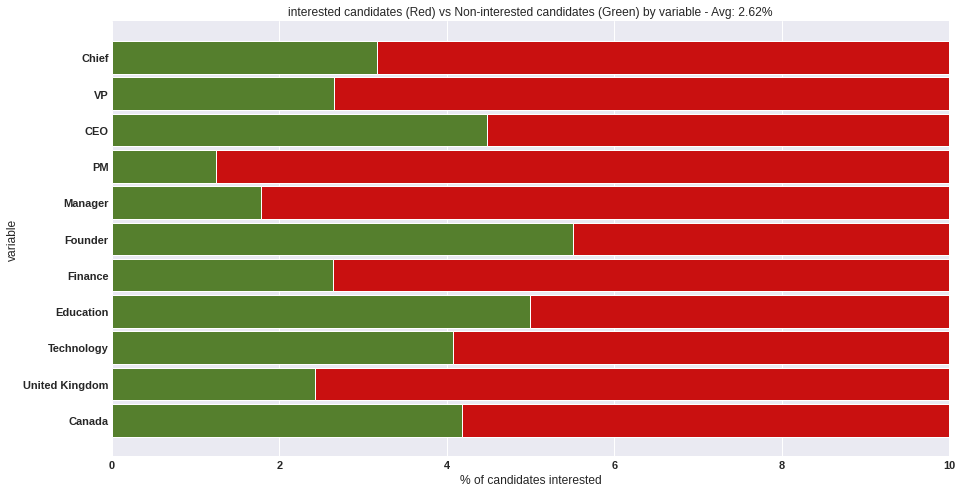

In [ ]:
f,ax=plt.subplots(figsize=(15,8))

# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars1 = [round(100*sum(df['interest']*df['canada'])/sum(df['canada']),2),
             round(100*sum(df['interest']*df['united_kingdom'])/sum(df['united_kingdom']),2),
             round(100*sum(df['interest']*df['technology'])/sum(df['technology']),2),
             round(100*sum(df['interest']*df['education'])/sum(df['education']),2),
             round(100*sum(df['interest']*df['finance'])/sum(df['finance']),2),
             round(100*sum(df['interest']*df['founder'])/sum(df['founder']),2),
             round(100*sum(df['interest']*df['manager'])/sum(df['manager']),2),
             round(100*sum(df['interest']*df['pm'])/sum(df['pm']),2),
             round(100*sum(df['interest']*df['ceo'])/sum(df['ceo']),2),
             round(100*sum(df['interest']*df['vp'])/sum(df['vp']),2),
             round(100*sum(df['interest']*df['chief'])/sum(df['chief']),2)]

bars2=[]
for i in bars1:
    bars2=bars2+[100-i]
  
# Heights of bars1 + bars2
#bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6,7,8,9,10]
 
# Names of group and bar width
names = ['Canada','United Kingdom','Technology','Education','Finance','Founder','Manager','PM','CEO','VP','Chief']
barWidth = 0.9
 
# Create noise bars
plt.barh( r,bars1, color='#557f2d', edgecolor='white',height=barWidth)
# Create unnoise bars
plt.barh(r, bars2, left=bars1, color='#c91010', edgecolor='white',height=barWidth)
 
# Custom X axis
plt.yticks(r, names, fontweight='bold')
plt.ylabel("variable")
plt.xlabel("% of candidates interested")
plt.title("interested candidates (Red) vs Non-interested candidates (Green) by variable - Avg: 2.62%")
plt.xlim(0, 10)  
# Show graphic
plt.show()

In [ ]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(15,7))
ax = sns.barplot(x=['1-10','11-50','51-200','201-500','501-1000','1001-5000','5001-10000','10001+'],
                 y=round(pd.crosstab(df['interest'], df['kw_size_num'], normalize ='columns',margins = False)*100,2).iloc[1],color='darkblue')
ax.set_title('% of candidates interested - Avg: 2.62%',fontsize=15)   
ax.set(xlabel="Company's number of employees", ylabel='% of interested');

NameError: ignored

### Descriptive analysis conclusions

1.  The percentage of people interested decrease, when the number of employees in the company where they worked increase. This is expectable because in big companies (with some time in the market) people can develop a career and are less willing to consider a change. 
2. Segment of people which could be more interested in a job position:
  - CEO
  - Founders
  - Canadian
  - Education employees
  - Technology employees
3. Segment of people which could be less interested in a job position:
  - Project managers
  - Manager



## Preprocessing Data

In [ ]:
# get the dependent and the independents variables
X=df[['united_kingdom', 'canada', 'kw_size_num',
       'technology', 'education', 'marketing', 'medicine', 'finance', 'owner',
       'founder', 'senior', 'manager', 'pm', 'consultant', 'specialist', 'ceo',
       'vp', 'partner', 'chief']]
y = df['interest']

The data was divided into two mutually exclusive subsets:
- **Train**: This subset is use to train the model.
- **Test**: This subset is use to verify that the model reproduce the desired results.

In [ ]:
# get train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

In [ ]:
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

## Classification Techniques


### Logistic Regression

In [ ]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.995, 0:0.005}, {1:0.99, 0:0.01}, {1:0.975, 0:0.025}, {1:0.965, 0:0.035}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid_lr = GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
                    param_grid=param_grid,
                    scoring='balanced_accuracy',
                    cv = 3, verbose=2, n_jobs = -1) 

#Fit the model
grid_lr = grid_lr.fit(Xtrain, ytrain)

#predict
ypred = grid_lr.predict(Xtest)

yproba = grid_lr.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  9.8min finished


Accuracy  :  0.585
Recall  :  0.64
Log Loss:  0.675


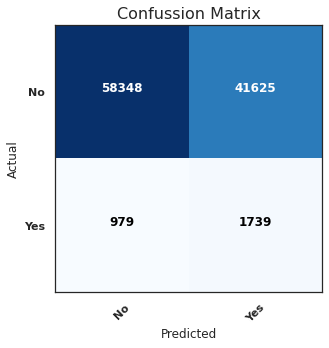

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
print("Accuracy  : ", round((tp + tn) / (tp + tn + fn + fp),3))
print("Recall  : ", round(tp / (tp + fn),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

### Decision tree classifier

In [ ]:
#List hyperparameters that we want to tune.
criterion = ['gini','entropy']
max_depth = list(range(1,15))
min_samples_leaf=list(range(1,15))
class_weight = [{1:0.995, 0:0.005}, {1:0.99, 0:0.01}, {1:0.975, 0:0.025}, {1:0.965, 0:0.035}]

#Convert to dictionary
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf,class_weight=class_weight)


In [ ]:
#from sklearn.model_selection import GridSearchCV
#Create new KNN object
model_tree = DecisionTreeClassifier()
#Use GridSearch
clf = RandomizedSearchCV(estimator=model_tree, 
                         param_distributions =hyperparameters, 
                         scoring='balanced_accuracy',
                         n_iter = 50, 
                         cv = 3, verbose=2, random_state=42, n_jobs = -1) 

#Fit the model
tree_best_model = clf.fit(Xtrain,ytrain)

#predict
ypred = tree_best_model.predict(Xtest)

yproba = tree_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


Accuracy  :  0.633
Recall  :  0.603
Log Loss:  0.669


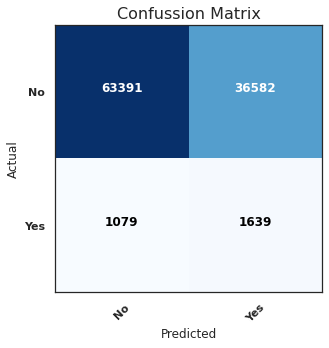

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
print("Accuracy  : ", round((tp + tn) / (tp + tn + fn + fp),3))
print("Recall  : ", round(tp / (tp + fn),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

### Random Forrest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(3,12))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf=list(range(1,15))
# Method of selecting samples for training each tree
bootstrap = [True, False]

class_weight = [{1:0.995, 0:0.005}, {1:0.99, 0:0.01}, {1:0.975, 0:0.025}, {1:0.965, 0:0.035}]

# Create the random grid
hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [ ]:
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_best_model = RandomizedSearchCV(estimator = rf, 
                               param_distributions = hyperparameters,
                               scoring='balanced_accuracy', 
                               n_iter = 50, cv = 3, verbose=4, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_best_model.fit(Xtrain, ytrain)

ypred = rf_best_model.predict(Xtest)
yproba = rf_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 57.7min finished


In [ ]:
rf_best_model.best_params_

{'bootstrap': True,
 'class_weight': {0: 0.025, 1: 0.975},
 'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 13,
 'min_samples_split': 5,
 'n_estimators': 166}

Accuracy  :  0.61
Recall  :  0.632
Log Loss:  0.657


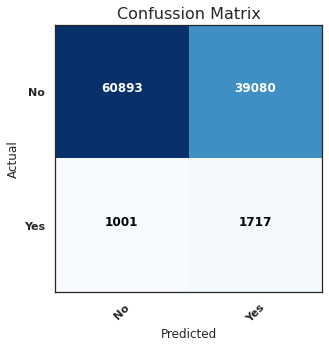

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# Measures : 
print("Accuracy  : ", round((tp + tn) / (tp + tn + fn + fp),3))
print("Recall  : ", round(tp / (tp + fn),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

In [ ]:
print('sucess rate: '+str(round(100*1717/40797,2)))
print('retaining rate: '+str(round(100*(39080+1717)/(39080+1717+1001+60893),2)))

sucess rate: 4.21
retaining rate: 39.73


### XgBoost

In [ ]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

one_to_left = st.beta(10, 1) #  Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

max_depth = list(range(3,12))
max_depth.append(None)

hyperparameters = {  
    "n_estimators": st.randint(50,200), # Number of boosted trees to fit.
    "max_depth": max_depth,     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
    'class_weight':[ {1:0.99, 0:0.01}, {1:0.975, 0:0.025}, {1:0.965, 0:0.035}, {1:0.95, 0:0.05}]
}

xgb_best_model = RandomizedSearchCV(estimator = model_xgb, 
                            param_distributions = hyperparameters,
                            scoring='balanced_accuracy',
                            n_iter = 50, cv = 3, verbose=4, 
                            random_state=42, n_jobs = -1)
xgb_best_model.fit(Xtrain, ytrain)

ypred = xgb_best_model.predict(Xtest)
yproba = xgb_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 91.4min finished


In [ ]:
xgb_best_model.best_params_

{'class_weight': {0: 0.035, 1: 0.965},
 'colsample_bytree': 0.8986481571053827,
 'gamma': 4.458327528535912,
 'learning_rate': 0.08998996632720116,
 'max_depth': 10,
 'min_child_weight': 7.674172222780436,
 'n_estimators': 153,
 'reg_alpha': 7.130725777960454,
 'subsample': 0.7642759106892745}

Accuracy  :  0.974
Recall  :  0.0
Log Loss:  0.118


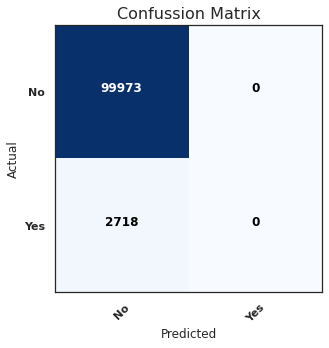

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

# Measures : 
tn, fp, fn, tp = cnf_matrix.ravel()

print("Accuracy  : ", round((tp + tn) / (tp + tn + fn + fp),3))
print("Recall  : ", round(tp / (tp + fn),3))
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))

In [ ]:
#Save models
with open(os.path.join(r'gdrive/My Drive/bairesdev/Models', 'scaler_interest.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
with open(os.path.join(r'gdrive/My Drive/bairesdev/Models', 'tree_classification.pkl'), 'wb') as f:
    pickle.dump(tree_best_model, f)
with open(os.path.join(r'gdrive/My Drive/bairesdev/Models', 'rf_classification.pkl'), 'wb') as f:
    pickle.dump(rf_best_model, f)
with open(os.path.join(r'gdrive/My Drive/bairesdev/Models', 'xgboost_classification.pkl'), 'wb') as f:
    pickle.dump(xgb_best_model, f)

## Final Selection and conclusions - part 1
For compare performance metric in each model, the following table was built:

| **Metric** | **Logistic** | **Tree** | **Random Forrest** | **XgBoost** |
|--|--|--|--|--|
| **Accuracy** | 0.585 | **0.633** | 0.61 | 0.974 |			
| **Recall** | **0.64** | 0.603 | 0.632 | 0.0  |	
| **Log Loss**| 0.675 |	0.669 |	**0.657** |	0.118 |
| **balanced accuracy**| 0.613 |0.618 | **0.621** | 0.487

Comparing the results among different techniques, Random Forest gives the best results. On the other hand, XGboost ends up being inclined to predict everything as non-interest for this reason it was not considered for comparison (it's like a "baseline").

if we only keep the data that we predict as a possible interest (39.7% of leads), instead of having a 2.6% success rate, we will have a 4.2%, which represents an increase of 61.8%, retaining 39.7% of leads.

#**Part 2 - Score prediction**

In this sesson, the aim is to consider only the people with interest in the job position and try to predict their score. This model involves a continuous positive (or zero) response variable, so regression techniques need to be used to get the suitable model.

## Descriptive analysis

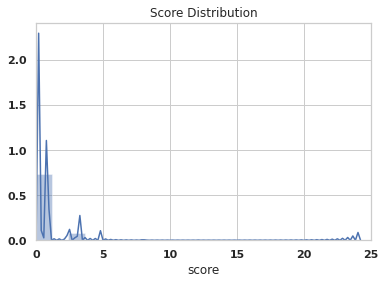

In [ ]:
df_interest=df[df.interest==1]

ax=sns.distplot(df_interest.score, bins=20) 
ax.set_xlim(0,25)
ax.set_title('Score Distribution');


As can be seen in the chart, the score reflects a relationship with the probability of being hired. It is known that Bairesdev hires only 1% of top developers. Therefore, it is observed that scores greater than 1 have a "high probability" of been hired (11.25% of leads) and scores less than 1 have a "very low probability" of been hired (88.75% of leads).

In [ ]:
pd.value_counts(df_interest.score).sort_index()

0.00       17
0.04     2355
0.10        4
0.20     5894
0.80     3692
2.40      429
3.20      797
4.80      223
7.20        3
8.00       27
12.00       5
16.00       1
24.00       7
Name: score, dtype: int64

In [ ]:
1-(5894+2355+3692)/13454

0.112457261780883

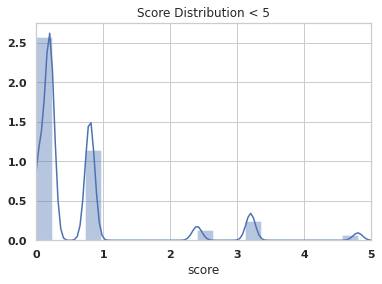

In [ ]:
ax=sns.distplot(df_interest.score[df_interest.score<5], bins=20) 
ax.set_xlim(0,5)
ax.set_title('Score Distribution < 5');

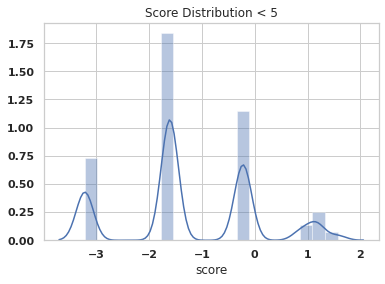

In [ ]:
#import math
ax=sns.distplot(np.log(df_interest.score[(df_interest.score>0)&(df_interest.score<5)]), bins=20) 
#ax.set_xlim(0,5)
ax.set_title('Score Distribution < 5');

In [ ]:
print('percentil of distribution')
round(df_interest.score.quantile(np.linspace(0.05, 1,19,endpoint=False)),2)

percentil of distribution


0.05    0.04
0.10    0.04
0.15    0.04
0.20    0.20
0.25    0.20
0.30    0.20
0.35    0.20
0.40    0.20
0.45    0.20
0.50    0.20
0.55    0.20
0.60    0.20
0.65    0.80
0.70    0.80
0.75    0.80
0.80    0.80
0.85    0.80
0.90    2.40
0.95    3.20
Name: score, dtype: float64

In [ ]:
round(df_interest.score.quantile(np.linspace(0.99, 1,10,endpoint=False)),2)

0.990    4.8
0.991    4.8
0.992    4.8
0.993    4.8
0.994    4.8
0.995    4.8
0.996    4.8
0.997    7.2
0.998    8.0
0.999    8.0
Name: score, dtype: float64

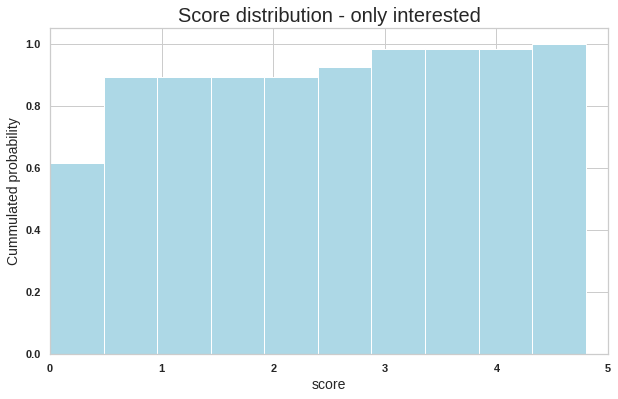

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('seaborn-darkgrid')
plt.xlim(0,5)
plt.axvline(x=100,color='red',linestyle='--');
plt.hist(df_interest.score[df_interest.score<5],bins=10, color="lightblue"
        , density=True, cumulative=True)
ax.set_xlabel('score', fontsize=14)
ax.set_title('Score distribution - only interested', fontsize=20)
ax.set_ylabel('Cummulated probability', fontsize=14);

In [ ]:
X=df_interest[['united_kingdom', 'canada', 'kw_size_num',
       'technology', 'education', 'marketing', 'medicine', 'finance', 'owner',
       'founder', 'senior', 'manager', 'pm', 'consultant', 'specialist', 'ceo',
       'vp', 'partner', 'chief']]
y = df_interest['score']

In [ ]:
# get train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

In [ ]:
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

## Regression techniques

### Baseline
A fundamental aspect of the models is to compare them with a baseline. In this case we will take as a baseline the error derived from estimating all the scores as the average score of the training data.

In [ ]:
base=ytrain.mean()
base

0.6932862584780842

In [ ]:
base=ytrain.mean()

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, [base] * len(ytest)))  
print('Mean Squared Error:', metrics.mean_squared_error(ytest, [base] * len(ytest)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, [base] * len(ytest))))

Mean Absolute Error: 0.6680784220463157
Mean Squared Error: 1.6106437862991252
Root Mean Squared Error: 1.2691114160305725


With this filter only 0.4% of the training data was deleted and outliers was avoided

In [ ]:
Xtrain=Xtrain[(ytrain>0)&(ytrain<5)]
ytrain=ytrain[(ytrain>0)&(ytrain<5)]

### Linear Regression

In [ ]:

ridge_params = {'alpha':list(range(1000, 3000, 1))}


reg_ridge_best_model =GridSearchCV(linear_model.Ridge(), param_grid=ridge_params , 
                                   scoring='neg_mean_absolute_error',
                                   n_jobs=-1,cv=5, verbose=2)

reg_ridge_best_model.fit(Xtrain, ytrain)

ypred = reg_ridge_best_model.predict(Xtest)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, ypred))  
print('Mean Squared Error:', metrics.mean_squared_error(ytest, ypred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 4540 tasks      | elapsed:   16.2s


Mean Absolute Error: 0.626754611352895
Mean Squared Error: 1.5236133129016103
Root Mean Squared Error: 1.2343473226371944


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   35.3s finished


In [ ]:
lasso_params = {'alpha':list(np.linspace(0, 0.1, 1000))}
reg_lasso_best_model =GridSearchCV(linear_model.Lasso(), param_grid=lasso_params,
                                   scoring='neg_mean_absolute_error',
                                   n_jobs=-1,cv=3, verbose=2)
reg_lasso_best_model.fit(Xtrain, ytrain)

ypred = reg_lasso_best_model.predict(Xtest)


print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, ypred))  
print('Mean Squared Error:', metrics.mean_squared_error(ytest, ypred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:    2.7s


Mean Absolute Error: 0.6264604622485749
Mean Squared Error: 1.522646334794954
Root Mean Squared Error: 1.233955564351875


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   11.7s finished


### Random forrest regressor

In [ ]:
max_depth = list(range(3,12))
max_depth.append(None)


parameters = {
    'n_estimators': list(range(10, 501, 10)), 
    'max_leaf_nodes': list(range(6, 60, 1)), 
    'max_depth': max_depth
}


reg_rf_best_model = RandomizedSearchCV(estimator=RandomForestRegressor(),
                       param_distributions = parameters, n_iter = 100,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1,cv=3, verbose=2)

reg_rf_best_model.fit(Xtrain, ytrain)

ypred = reg_rf_best_model.predict(Xtest)


print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, ypred))  
print('Mean Squared Error:', metrics.mean_squared_error(ytest, ypred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.1min finished


Mean Absolute Error: 0.6161252578221714
Mean Squared Error: 1.5012927705395698
Root Mean Squared Error: 1.2252725290887614


### XGboost Regressor

In [ ]:
max_depth = list(range(3,12))
max_depth.append(None)

parameters = {
    'n_estimators':  list(range(10, 501, 10)), 
    'learning_rate': [x / 100 for x in range(5, 10, 1)], 
    'max_depth': max_depth
}

reg_xg_best_model = RandomizedSearchCV(estimator=XGBRegressor(objective='reg:squarederror'),
                       param_distributions = parameters, n_iter = 50,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1,cv=3, verbose=2)

reg_xg_best_model.fit(Xtrain, ytrain)

ypred = reg_xg_best_model.predict(Xtest)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, ypred))  
print('Mean Squared Error:', metrics.mean_squared_error(ytest, ypred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.1min finished


Mean Absolute Error: 0.5955066037381817
Mean Squared Error: 1.5521869585558525
Root Mean Squared Error: 1.2458679539003532


## Final Selection and conclusions - part 2
Comparing the assess metric in each model, we have:

| **Metric** | **Baseline** | **Ridge** | **Lasso** | **Random Forrest** | **XgBoost** |
|--|--|--|--|--|--|
| **Mean Absolute Error** | 0.668 | 0.626 | 0.626 | 0.614 | **0.596** |			
| **Mean Squared Error** | 1.610 | 1.523 | 1.522 | **1.498** | 1.554  |	
| **Root Mean Squared Error**| 1.269 | 1.234 |	1.234 |	**1.224** |	1.246 |


Random Forest is the technique that produces the best results in the Root Mean Squared Error measure which is the most confident. The baseline is improved by 3.55% using this technique.

The logarithmic transformation in the response variable was tested, but the results were not satisfactory.


In [ ]:
#Save models
with open(os.path.join(r'gdrive/My Drive/bairesdev/Models', 'scaler_score.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
with open(os.path.join(r'gdrive/My Drive/bairesdev/Models', 'rf_regression.pkl'), 'wb') as f:
    pickle.dump(reg_rf_best_model, f)
with open(os.path.join(r'gdrive/My Drive/bairesdev/Models', 'xgboost_regression.pkl'), 'wb') as f:
    pickle.dump(reg_xg_best_model, f)

# **Part 3 - New leads predictions**

In [ ]:
# Import multiples csv files from a folder and concatenate in a only dataFrame

path = r'gdrive/My Drive/bairesdev/Data' # path
all_data_csv = glob.glob(path + "/Data[0-9]*.xls")

li = []

for filename in all_data_csv:
    df = pd.read_csv(filename, index_col=None,sep=',', error_bad_lines=False) 
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.head()

b'Skipping line 12989: expected 7 fields, saw 9\n'
b'Skipping line 42920: expected 7 fields, saw 8\n'


,idlead,title,country,state,city,kw_industry,kw_size
0,4000001,Managing Principal,United States,DC,Washington D.C. Metro Area,Management Consulting,11-50 employees
1,4000002,Principal,United States,MD,"Baltimore, Maryland Area",Management Consulting,1-10 employees
2,4000003,Principal,United States,TX,"Austin, Texas Area",Management Consulting,11-50 employees
3,4000018,Principal Consultant,United States,AZ,"Phoenix, Arizona Area",Management Consulting,11-50 employees
4,4000025,Owner,United States,CA,Greater Los Angeles Area,Computer Games,1-10 employees


In [ ]:
idlead=df.idlead
df=df.set_index(idlead)

df.drop(columns=['idlead'], inplace=True)

#fill uncommon data or missing with the most common value
df['country']=np.where(df.country=='United kingdom','United Kingdom',df.country)
df['country']=np.where(df.country.isin(['United States','United Kingdom','Canada']),df.country,'United States')
df['country'].fillna('United States',inplace=True) 

df['united_kingdom']=np.where(df.country=='United Kingdom',1,0)
df['canada']=np.where(df.country=='Canada',1,0)

df.drop(columns=['country'], inplace=True)

#fill missing data
df['kw_size'].fillna('TBD',inplace=True)

#delete an incoherent point
df=df[df.kw_size!='2020-03-02']

#map company's size (1 the lowest, 8 the biggest)
employees={'1-10 employees':1,
           '11-50 employees':2,
           '51-200 employees':3,
           '201-500 employees':4,
           '501-1000 employees':5,
           '1001-5000 employees':6,
           '5001-10000 employees':7,
           '10001+ employees':8}
df.loc[:,'kw_size_num']= df['kw_size'].map(employees)

df.drop(columns=['kw_size'], inplace=True)

df.kw_industry=[x.lower() for x in list(df.kw_industry)]
df['kw_industry'].fillna('TBD',inplace=True)

technology=['computer & network security','internet', 'security and investigations', 'computer games', 'computer hardware', 'computer networking',
 'computer software', 'consumer electronics', 'information services', 'information technology and services']

education=['e-learning', 'education management', 'educational institution','higher education','primary/secondary education',
           'professional training & coaching']

marketing=['broadcast media', 'market research', 'marketing and advertising', 'media production', 'online media','publishing']

medicine=['alternative medicine','biotechnology','chemicals','health wellness and fitness','hospital & health care', 'medical devices', 
          'medical practice', 'mental health care','nanotechnology','pharmaceuticals','veterinary',]
          
finance=['banking','fund-raising','capital markets', 'commercial real estate','financial services','fine art', 'insurance', 'investment banking',
         'investment management','philanthropy', 'real estate']
         
df['technology']=np.where(df.kw_industry.isin(technology),1,0)
df['education']=np.where(df.kw_industry.isin(education),1,0)
df['marketing']=np.where(df.kw_industry.isin(marketing),1,0)
df['medicine']=np.where(df.kw_industry.isin(medicine),1,0)
df['finance']=np.where(df.kw_industry.isin(finance),1,0)

df.drop(columns=['kw_industry'], inplace=True)
df.drop(columns=['state'], inplace=True)

df['title'].fillna('TBD',inplace=True)
df.title=[x.lower() for x in list(df.title.astype(str))]

# Main Work positions
df['owner']=np.where(df.title=="owner",1,0)
df['founder']=np.where(df.title.str.contains("founder"),1,0)
df['senior']=np.where(df.title.str.contains("senior"),1,0)
df['manager']=np.where((df.title.str.contains("manager"))&(df.title!="project manager")&(df.title!="account manager"),1,0)
df['pm']=np.where((df.title=="PM")|(df.title=="project manager")|(df.title=="project coordinator"),1,0)
df['consultant']=np.where(df.title.str.contains("consultant"),1,0)
df['specialist']=np.where(df.title.str.contains("specialist"),1,0)

df['ceo']=np.where((df.title=="director")|(df.title=="president")|(df.title=="chairman")|(df.title.str.contains("ceo")|(df.title=="managing director")),1,0)
df['vp']=np.where((df.title=="vp")|(df.title.str.contains("vice president"))|(df.title.str.contains(" vp")),1,0)
df['partner']=np.where((df.title.str.contains("partner"))|(df.title.str.contains("associate")),1,0)
df['chief']=np.where((df.title.str.contains("chief"))|(df.title.str.contains("cfo"))|(df.title.str.contains("cto"))
|(df.title.str.contains("coo"))|((df.title.str.contains("director")) & (df.title!="director"))
|((df.title.str.contains("president")) & (df.title!="president") & (-df.title.str.contains("vice president"))),1,0)

df.drop(columns=['title'], inplace=True)
df.drop(columns=['city'], inplace=True)


X=df[['united_kingdom', 'canada', 'kw_size_num',
       'technology', 'education', 'marketing', 'medicine', 'finance', 'owner',
       'founder', 'senior', 'manager', 'pm', 'consultant', 'specialist', 'ceo',
       'vp', 'partner', 'chief']]

scaler_interest=pd.read_pickle('gdrive/My Drive/bairesdev/Models/scaler_interest.pkl')
X=scaler_interest.transform(X)

rf_best_model=pd.read_pickle('gdrive/My Drive/bairesdev/Models/rf_classification.pkl')
df['pred_interest'] = rf_best_model.predict(X)
df['prob_interest'] = rf_best_model.predict_proba(X)[:,1]

X=df[['united_kingdom', 'canada', 'kw_size_num',
       'technology', 'education', 'marketing', 'medicine', 'finance', 'owner',
       'founder', 'senior', 'manager', 'pm', 'consultant', 'specialist', 'ceo',
       'vp', 'partner', 'chief']]

scaler_score=pd.read_pickle('gdrive/My Drive/bairesdev/Models/scaler_score.pkl')
X=scaler_score.transform(X)

reg_rf_best_model=pd.read_pickle('gdrive/My Drive/bairesdev/Models/rf_regression.pkl')
df['pred_score']  = reg_rf_best_model.predict(X)

df['estimated_value'] = df['pred_score']*df['prob_interest'] 

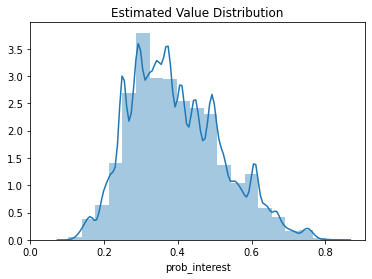

In [ ]:
ax=sns.distplot(df['prob_interest'], bins=20) 
ax.set_xlim(0)
ax.set_title('Probability of Interest distribution');

As previously mentioned, the distribution shows the propensity of the model for false positives (people we predict as interested leads who are not really interested).

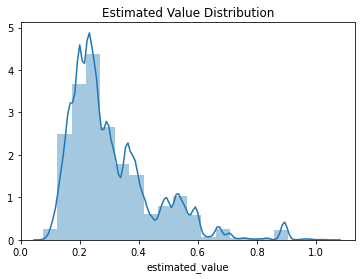

In [ ]:
ax=sns.distplot(df['estimated_value'], bins=20) 
ax.set_xlim(0)
ax.set_title('Estimated Value Distribution');

Fortunately, the distribution of the value shows that there are a significant number of people potentially more valuable than the rest.

## How many people are going to send in the list?
To answer this question it is known:
- BairesDev mission is "We lead the digital transformation of companies worldwide driven by the Top 1% IT Talent", for this reason it is assumed that only 1% of the leads interested are finally hired.
- From the task letter, it is evident that the list must ensure at least the hiring of a big team of 20 developers.

## First Attempt
A Bernoulli distribution with probability 0.01 will be simulated to determine how many interested leads we must have to recruit 20 developers.

In [ ]:
simulation=[]
p_hired=0.01
for i in range(0,1000):
  counter=0
  hired=0
  while (hired<20):
    hired+=sum(bernoulli.rvs(p=p_hired, size=10))
    counter+=10
  simulation.append(counter)

In [ ]:
pd.DataFrame(simulation,columns=["Interest people's distribution"]).describe()

,Interest people's distribution
count,1000.000000
mean,2003.910000
std,444.751184
min,770.000000
25%,1700.000000
50%,1965.000000
75%,2280.000000
max,3800.000000


It is evident that to hire 20 people with a probability of 75%, it is necessary to generate interest in 2,280 people. On the other hand, the interest model has a false positive rate of 95.79%. Therefore, it is concluded that 54,157 people estimated as "interested" are needed.

In [ ]:
df_reduce=df.sort_values(by='estimated_value',ascending=False)[['pred_interest', 'prob_interest', 'pred_score','estimated_value']]
df_reduce['cumulative_pred_interest'] = df_reduce['pred_interest'].cumsum()
df_reduce=df_reduce[df_reduce.cumulative_pred_interest<54157]

In [ ]:
print('Percentage of the total needed to get 20 employees: '+str(100*df_reduce.shape[0]/df.shape[0]))

Percentage of the total needed to get 20 employees: 33.47573390293561


## Second Attempt

Only those leads whose score is greater than 1 will be kept, since it was observed that they have higher probability of 
being hired (8.9%). A Bernoulli distribution with probability 0.089 will be simulated to determine how many interested leads we must have to recruit 20 developers.

In [ ]:
simulation=[]
p_hired=0.089
for i in range(0,1000):
  counter=0
  hired=0
  while (hired<20):
    hired+=sum(bernoulli.rvs(p=p_hired, size=1))
    counter+=1
  simulation.append(counter)

In [ ]:
pd.DataFrame(simulation,columns=["Interest people's distribution"]).describe()

,Interest people's distribution
count,1000.000000
mean,224.997000
std,48.307003
min,96.000000
25%,191.000000
50%,222.000000
75%,253.000000
max,443.000000


In [ ]:
df_reduce2=df[df.pred_score>1]
df_reduce2=df_reduce2.sort_values(by='estimated_value',ascending=False)[['pred_interest', 'prob_interest', 'pred_score','estimated_value']]

It is evident that to hire 20 people with a probability of 75%,  it is necessary to generate interest in 253 people. On the other hand, the interest model has a false positive rate of 95.79%. Therefore, it is concluded that 6010 people estimated as "interested" are needed.

In [ ]:
print('Total high score - interested: '+str(df_reduce2['pred_interest'].sum()))

Total high score - interested: 25853


In [ ]:
print('Total high score: '+str(df_reduce2.shape[0]))

Total high score: 86299


In [ ]:
df_reduce2['cumulative_pred_interest'] = df_reduce2['pred_interest'].cumsum()
df_reduce2=df_reduce2[df_reduce2.cumulative_pred_interest<=6010]

In [ ]:
print('Percentage of the total needed to get 20 employees - base high score: '+str(100*df_reduce2.shape[0]/df.shape[0]))

Percentage of the total needed to get 20 employees - base high score: 1.202004808019232


In [ ]:
df_send=df[(df.pred_score>1)&(df.pred_interest==1)]
df_send=df_send.sort_values(by='estimated_value',ascending=False)[['pred_interest', 'prob_interest', 'pred_score','estimated_value']]
pd.DataFrame(df_send.index).to_csv('gdrive/My Drive/bairesdev/leads_list.csv',index=False)

## Conclusions:

In this second attempt, the initial database was considerably reduced, achieving the aim of hire 20 persons (probability of 75%) with only 1.20% of the entire database. 

This action will reduce costs of sending emails, since it significantly reduces the number of uninterested leads and will reduce HR costs since those possible interested leads are only contacted if their estimated score is high.

In the final list, the entire base of high score and probability of interest consisting of 25,853 leads will be sent.